# Análise exploratória:

In [ ]:
import pandas as pd

df = pd.read_csv("ml_project1_data.csv")

#Sweetviz:
import sweetviz
report = sweetviz.analyze(df)
report.show_html('report1_sweetviz.html')

#Gerei um relatório também pelo Pandas Profiling, para comparar os dois estilos de visualização,
#mas optei por aproveitar somente alguns graficos do Sweetviz no relatorio:

from pandas_profiling import ProfileReport
report = ProfileReport(df)
report.to_file(output_file = 'report1_pandas_profiling.html')

# Transformações:

C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


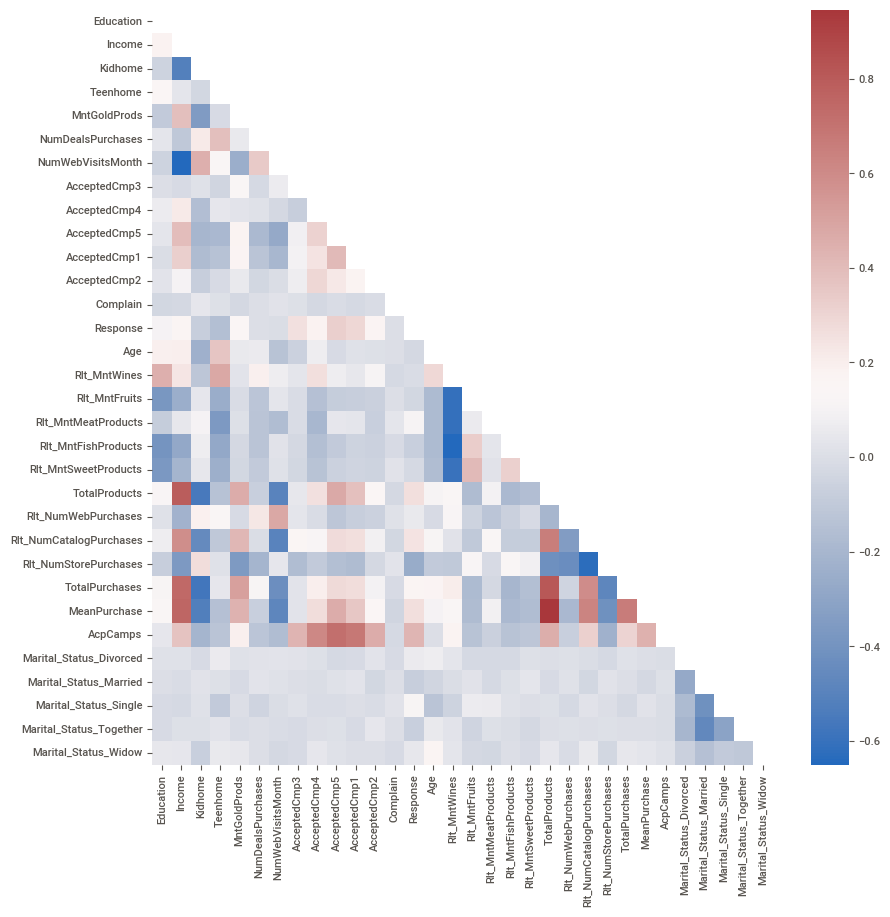

In [300]:
#Calcula o valor relativo percentual, por linha, de um grupo de colunas:
def v_relat(X, tot=None):
    Sm = X.sum(axis=1)
    for k in X.columns:
        X.loc[:,k] = X.loc[:,k]/Sm * 100
    X = X.round(2)
    X.columns = ["Rlt_" + k for k in X.columns]
    
    if tot is not None: #Adiciona coluna com o total:
        X.loc[:,tot] = Sm
        
    X = X.fillna(0)
    
    return(X)

import pandas as pd
df = pd.read_csv("ml_project1_data.csv", index_col=0)

#Imputacao dos missing values de Income pela mediana:
df.Income.fillna(df.Income.median())

#Correcoes:
df.loc[df["Marital_Status"].isin(["Alone", "Absurd", "YOLO"]) , "Marital_Status"] = "Single"

#------------------ Novas variaveis ------------------

df.loc[:,"Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
df.loc[:,"Age"] = df["Dt_Customer"].dt.year - df["Year_Birth"]

#Transformacoes para valores relativos e somas:
#Visa identificar o tipo de produto de interesse do consumidor:
Relat_Prod = v_relat(df[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts"]], tot="TotalProducts")
df = pd.concat([df, Relat_Prod], axis=1)
df = df.drop(columns=["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts"])

#Visa identificar o canal de venda peferido do cliente:
Relat_Purch = v_relat(df[["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]], tot="TotalPurchases")
df = pd.concat([df, Relat_Purch], axis=1)
df = df.drop(columns=["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"])

#Faturamento medio por compra:
df.loc[:,"MeanPurchase"] = (df["TotalProducts"] + 1) / (df["TotalPurchases"] + 1) #Adicionou-se 1 ao numerador e denominador para evitar erro de divisao por zero
df.loc[:,"MeanPurchase"] = df["MeanPurchase"].round(2)

#Aceitacao de campanhas - para identificar clientes que responderam mais as campanhas de marketing:
df.loc[:,"AcpCamps"] = df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] +df["AcceptedCmp4"] + df["AcceptedCmp5"]

#Produtos Gold x Produtos Regulares (percentual):
#Tentei calcular o percentual de quantos produtos sao gold ou regulares, entretanto observei que existem muitos registros
#que MntGoldProds > TotalProducts (o que nao faz sentido se GoldProds/RegularProds e uma categoria a parte, como explicado no case),
#entao resolvi nao realizar essa transformacao:

#df.loc[:,"MntGoldProds"] = df["MntGoldProds"] / df["TotalProducts"] *100
#df.loc[:,"MntGoldProds"] = df.loc[:,"MntGoldProds"].round(2)
#df.loc[:,"MntRegularProds"] = (df["TotalProducts"] - df["MntGoldProds"]) / df["TotalProducts"] *100
#df.loc[:,"MntRegularProds"] = df.loc[:,"MntRegularProds"].round(2)

#------------------  ------------------

#Tratamento de outliers - remocao:
df = df.loc[df["Income"] < 200000,:]
df = df.loc[df["Age"] < 100,:]

#Codificacao ordinal - Education:
df["Education"] = df["Education"].replace({"Basic": 1, "2n Cycle": 2, "Graduation": 3, "Master": 4, "PhD": 5})

#Codificacao one-hot - Material_Status:
Marital_Status = pd.get_dummies(df.Marital_Status, prefix='Marital_Status')
df = pd.concat([df, Marital_Status], axis=1)

#Remocao de colunas:
df = df.drop(columns=["Recency", "Marital_Status", "Z_CostContact", "Z_Revenue", "Dt_Customer", "Year_Birth"])

#Conferencia de missing values:
#print(df.isnull().sum())

#Salva:
df.to_csv("dataset_clean.csv", sep=";", decimal=",") #costumo salvar separado por ; para facilitar o uso no excel em portugues

#Gera novo report - pandas_profiling (nao usado):
#from pandas_profiling import ProfileReport
#report = ProfileReport(df)
#report.to_file(output_file = 'report_clean.html')

#Gera novo report - sweetviz:
#import sweetviz
#report = sweetviz.analyze(df)
#report.show_html('report2_sweetviz.html')

#Grafico de correlacao:
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10,10))
mask = np.triu(np.ones_like(df.corr()))
cor = sb.heatmap(df.corr(), cmap="vlag", annot=False, mask=mask, ax=ax) 
plt.show()


# Seguimentação de Clientes:



1 - Por produto de interesse


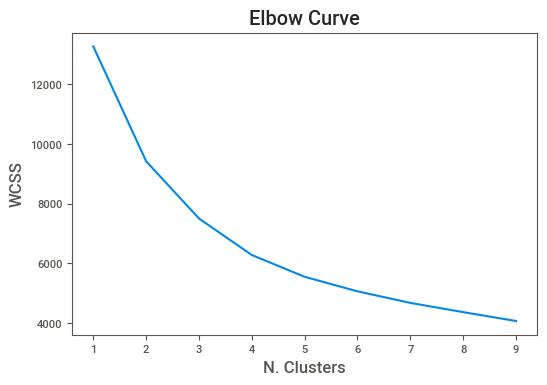

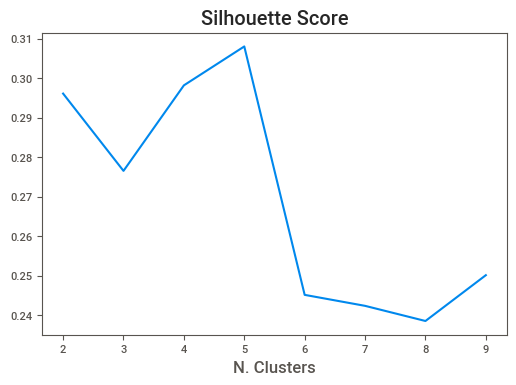

Num. ideal clusters - Silhouette Score:  5 0.3080444266596391
Num. ideal clusters - Elbow Curve:  6


2 - Por Nivel de Consumo


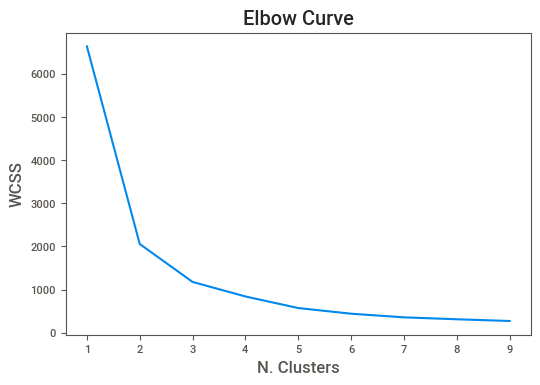

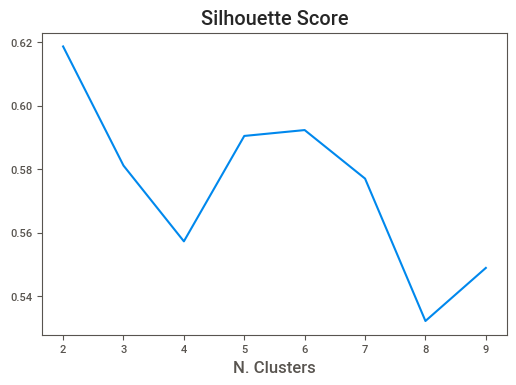

Num. ideal clusters - Silhouette Score:  2 0.6187220363706241
Num. ideal clusters - Elbow Curve:  4


In [302]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

#Funcao para definicao do numero de cluster pelo metodo Elbow Curve e Silhouette Score:
def Def_N_Clusters(df, max_cl=10):
    wcss = [] #Within Sum of Squares
    silhouette = []

    for i in range(1, max_cl):
        kmeans = KMeans(n_clusters = i, max_iter = 300, random_state = 0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        
        if i > 1:
            preds = kmeans.predict(df)
            silhouette.append(silhouette_score(df, preds))
    
    plt.plot(range(1, max_cl), wcss)
    plt.title('Elbow Curve')
    plt.xlabel('N. Clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    plt.plot(range(2, max_cl), silhouette)
    plt.title('Silhouette Score')
    plt.xlabel('N. Clusters')
    plt.show()
    
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = ((y2 - y1)**2 + (x2 - x1)**2)**.5
        distances.append(numerator/denominator)
    
    print("Num. ideal clusters - Silhouette Score: ", silhouette.index(max(silhouette)) + 2, max(silhouette))
    print("Num. ideal clusters - Elbow Curve: ", distances.index(max(distances)) + 2)
#-----------------------------------------------

df = pd.read_csv("dataset_clean.csv", sep=";", decimal=",")

std = StandardScaler()

print("\n\n1 - Por produto de interesse")

d = df[["Rlt_MntWines", "Rlt_MntFruits", "Rlt_MntMeatProducts", "Rlt_MntFishProducts", "Rlt_MntSweetProducts", "MntGoldProds"]]
d = std.fit_transform(d)
Def_N_Clusters(d)

kmeans = KMeans(n_clusters = 5, max_iter = 300, random_state = 0)
df["InterestGroup"] = kmeans.fit_predict(d)+1


print("\n\n2 - Por Nivel de Consumo")

d = df[["TotalProducts", "TotalPurchases", "MeanPurchase"]]
d = std.fit_transform(d)

Def_N_Clusters(d)
kmeans = KMeans(n_clusters = 2, max_iter = 300, random_state = 0)
df["ConsumptionLevel"] = kmeans.fit_predict(d)+1

df.to_csv("clusters.csv", sep=";", decimal=",")

In [749]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

def aplica_cutoff(prob, cutoff):
    prob = np.array(prob)[:,1] #Probabilidade da classe 1
    
    pred = np.zeros(len(prob))
    pred[prob > cutoff] = 1
    return(pred)

def metricas(pred, real):
    #Metricas especificas da modelagem:
    receita = pred * real * 11 #$11 de receita por acerto
    receita = receita.sum()
    disparo = pred.sum()
    if disparo == 0:
        return(None)
    
    lucro = receita - disparo * 3 #$3 de custo por disparo
    
    lucro_max = real * 11 #Lucro supondo 100% de acerto
    lucro_max = lucro_max.sum()
    
    lucro_disparo = round(lucro / disparo, 3) #Lucro por disparo
    proporcao = round(disparo / len(pred) * 100, 2) #Proporção de disparos em relação a base de dados
    eficiencia = round(lucro/lucro_max * 100, 2) #Percentual de lucro alcancado, em relacao ao maximo possivel

    #Metricas tradicionais:
    acuracia = accuracy_score(real, pred)
    precisao = precision_score(real, pred)
    recall = recall_score(real, pred)

    return([eficiencia, lucro_disparo, proporcao, acuracia, precisao, recall])

def treina_kfold(df, rep=5, cutoffs = [.5]):
    res = []
    for cut in cutoffs:
        for k in range(rep):
            df_treino = df.sample(frac=.8)
            df_teste = df.drop(df_treino.index)

            Y_treino = df_treino.loc[:, "Response"]
            X_treino = df_treino.drop(columns="Response")
            Y_teste = df_teste.loc[:, "Response"]
            X_teste = df_teste.drop(columns="Response")

            Md = DecisionTreeClassifier(max_depth=10)
            Md.fit(X_treino, Y_treino)

            prob = Md.predict_proba(X_teste)
            pred = aplica_cutoff(prob, cut)
            
            mt = metricas(pred, Y_teste)
            if mt is None:
                continue
                
            l = [cut]
            l.extend(mt)
            res.append(l)
        print("|", end="")
    print("\n")
    
    res = pd.DataFrame(res, columns=["Cutoff", "Eficiencia", "Lucro_por_Disparo", "Percentual_Disparos", "Acuracia", "Precisao", "Recall"])
    res = res.groupby("Cutoff").agg(["mean", "std"]).round(2)
    return(res)

df = pd.read_csv("clusters.csv", sep=";", decimal=",", index_col=0)
df = df[['Response', 'InterestGroup', 'ConsumptionLevel', 'AcpCamps']]    

res = treina_kfold(df, rep=100, cutoffs = [.15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7])

#Cenarios - Nive de confianca de 95% (2 desvios padroes):
#Para cada 10 mil clientes na base:

#caso Lucro por Disparo seja negativo descontando-se 2 desios padroes, o pior cenario e o com maior proporcao de disparos, por isso avalia-se os dois casos:
pior_cenario_1 = (res[("Lucro_por_Disparo", "mean")] - 2*res[("Lucro_por_Disparo", "std")]) * (res[("Percentual_Disparos", "mean")] - 2*res[("Percentual_Disparos", "std")]) * 100
pior_cenario_2 = (res[("Lucro_por_Disparo", "mean")] - 2*res[("Lucro_por_Disparo", "std")]) * (res[("Percentual_Disparos", "mean")] + 2*res[("Percentual_Disparos", "std")]) * 100
pior_cenario = pd.concat([pior_cenario_1, pior_cenario_2], axis = 1).min(axis = 1)
res["lucro_pior_cenario_10k"] = pior_cenario
res["lucro_provavel_10k"] = res[("Lucro_por_Disparo", "mean")] * res[("Percentual_Disparos", "mean")] * 100
res["lucro_melhor_cenario_10k"] = (res[("Lucro_por_Disparo", "mean")] + 2*res[("Lucro_por_Disparo", "std")]) * (res[("Percentual_Disparos", "mean")] + 2*res[("Percentual_Disparos", "std")]) * 100

res.to_csv("resultados_modelagem_campanha.csv", sep=";", decimal=",")
print(res)

||||||||||||

       Eficiencia       Lucro_por_Disparo       Percentual_Disparos        \
             mean   std              mean   std                mean   std   
Cutoff                                                                      
0.15        16.50  5.89              1.34  0.55               20.78  2.52   
0.20        17.72  4.89              1.59  0.57               19.16  2.35   
0.25        17.63  4.71              2.02  0.76               15.36  3.01   
0.30        18.75  4.30              2.71  0.75               11.67  1.79   
0.35        16.92  4.17              2.93  0.77                9.82  2.24   
0.40        16.05  3.62              3.70  0.97                7.45  1.67   
0.45        14.98  3.58              3.87  0.92                6.37  1.18   
0.50        13.62  3.66              4.32  1.20                5.19  1.19   
0.55        13.23  3.42              4.79  1.21                4.62  1.09   
0.60        12.04  3.24              5.10  0.99               

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

df = pd.read_csv("clusters.csv", sep=";", decimal=",", index_col=0)

df = df[['Response', 'InterestGroup', 'ConsumptionLevel', 'AcpCamps']]

df_treino = df.sample(frac=.9)
df_teste = df.drop(df_treino.index)
    
Y_treino = df_treino.loc[:, "Response"]
X_treino = df_treino.drop(columns="Response")
Y_teste = df_teste.loc[:, "Response"]
X_teste = df_teste.drop(columns="Response")
    

    

def aplica_cutoff(prob, cutoff):
    pred = np.zeros(len(prob))
    pred[prob > cutoff] = 1
    return(pred)

def prev_lucro(prev, real):
    receita = prev * real * 9 #$11 de receita - $3 de custo
    receita = receita.sum()
    custo = prev.sum() * 3 #$3 de custo
    lucro = receita - custo
    
    lucro_max = real * 9 #Lucro supondo 100% de acerto
    lucro_max = lucro_max.sum()
    
    res = round(lucro/lucro_max * 100, 2) #Percentual de lucro alcancado, em relacao ao maximo possivel
    prop = round(prev.sum() / len(prev), 2)

    return(res, prop)
    
def otimiza_cutoff(prob, real):
    rg = [k * .01 for k in range(20, 70)]
    
    res = []
    for cut in rg:
        prev = aplica_cutoff(prob, cut)
        lucro, prop = prev_lucro(prev, real)
        res.append([cut, prev_lucro(prev, real), accuracy_score(real, prev), precision_score(real, prev), recall_score(real, prev)])
    
    #seleciona melhor resultado:
    res = pd.DataFrame(res, columns=["Cutoff", "Lucro", "Prop", "Acuracia", "Precisao", "Recall"])
    res = res.loc[res["Lucro"] == res["Lucro"].max(),:]
    res = res.mean()
    return(res)

def treina_md(df, rnd):
    df_treino = df.sample(frac=.7, random_state=rnd)
    df_val = df.drop(df_treino.index) #grupo de validacao
    
    Y_treino = df_treino.loc[:, "Response"]
    X_treino = df_treino.drop(columns="Response")
    Y_val = df_val.loc[:, "Response"]
    X_val = df_val.drop(columns="Response")

    Md = DecisionTreeClassifier(max_depth=10, class_weight={0:1, 1:1}, random_state=rnd)
    Md.fit(X_treino, Y_treino)
    return(Md, Y_treino, X_treino, Y_val, X_val)

def treino(df, rep):
    res = pd.DataFrame()
    for rnd in range(rep):
        Md, Y_treino, X_treino, Y_val, X_val = treina_md(df, rnd)

        prob = np.array(Md.predict_proba(X_val))[:,1] #Probabilidade de pertencer a classe 1

        res = pd.concat([res, pd.DataFrame([otimiza_cutoff(prob, Y_val)])], axis=0)
        print("|", end="")
    
    #seleciona a melhor arvore:
    res = res.reset_index(drop=True)
    res = res.loc[res["Lucro"] == res["Lucro"].max(),:]
    print("\n")
    print(res)

#treino(df_treino, 1000)
Md, Y_, X_, Y_val, X_val = treina_md(df_treino, 155)

prob = np.array(Md.predict_proba(X_teste))[:,1] #Probabilidade de pertencer a classe 1
prev = aplica_cutoff(prob, 0.7)

real = Y_teste
print(prev_lucro(prev, real), accuracy_score(real, prev), precision_score(real, prev), recall_score(real, prev))

Md = DecisionTreeClassifier(max_depth=6)
Md.fit(X_treino, Y_treino)
prev = Md.predict(X_teste)
print(prev_lucro(prev, real), accuracy_score(real, prev), precision_score(real, prev), recall_score(real, prev))

#otimiza_cutoff(prob, Y_teste)